In [1]:
#| default_exp normalization

## Within-condition normalization
It is common practice and highly recommended to measure multiple samples of a given condition. This ensures that observed changes between conditions are not just due to random variation. Examples of samples within the same condition could be biological replicates, but also patients with the same clinical condition. 
We want to ensure that systematic changes between within-condition samples are corrected for as follows:

* Our assumed input values are log2 transformed peptide ion intensities, which are stored in a 2d numpy array called "samples". Each row in samples represents a peptide and each column represents a sample

* In a first step, we determine the all pairwise distances between the samples (details explained below)
* We then choose the pair of samples with the closest distance between each other
* We randomly choose one "anchor" sample and one "shift" sample and we subtract the distance between the samples from each peptide intensity measured in the "shift" sample. This is equivalent to rescaling the intensities of the original sample by a constant factor such that the distributions are aligned
* We then construct a virtual "merged" sample by computing the average intensities of anchor and shift sample
* We repeat the steps above until all samples are merged. Keeping track of the shift factors allows us then to determine an ideal shift for each sample



### Find the best matching pair
Take all pairs of the columns in the "samples" array that have not been already merged and compute the distance between the pairs as follows:
* Subtract sample1 from sample2 (or sample2 from sample1, the order does not matter)
* This results in a distribution of differences. As the samples array contains log2 intensities, this corresponds to taking log2 fold changes
* Take the median of the distribution, this is a good approximation for the change between the two distributions
* Select the two samples with the lowest absolute change

### Shifting samples
When we have computed the distance between two samples, we want to correct one of the samples by this distance. This results in two distributions with the same median value. We always shift the sample which has been merged from fewer distributions (see below for details). The sample to which the shift is applied is call "shift" sample and the sample which is not shifted is called "anchor" sample.
A "total shift" is calculated after all samples are merged, just by following up how many shifts have been applied to a sample in total

### Merging distributions
After we shift two distributions on top of each other, we calculate a "merged" distribution. Each intensity in the merged distribution is the average of the intensity in both distributions. For the merging we have to take into account the following: If for example the anchor sample has already been merged from 10 samples, and the shift distribution has not been merged at all, we want to weigh the distribution coming from many samples higher. We hence multiply each sample by the number of merges.

## Wrapper functions

## Shift linear to reference

## Unit tests

In [16]:
#| include: false
import numpy as np
import directlfq.normalization as norm

def test_merged_distribs():
    anchor_distrib = np.array([1, 1, 1, 1, 1])
    shift_distrib = np.array([2, 2, 2, 2, 2])
    counts_anchor_distrib = 4
    counts_shifted_distib = 1
    assert (merge_distribs(anchor_distrib, shift_distrib, counts_anchor_distrib, counts_shifted_distib)== np.array([1.2, 1.2, 1.2, 1.2, 1.2])).any()


In [17]:

test_merged_distribs() 

In [18]:
#| include: false
import numpy as np
import pandas as pd


def test_order_of_shifts():
    vals1 = [1, np.nan, 1.5]
    vals2 = [1, 1, np.nan]
    vals3 = [3.2, 1, 2.8]
    vals4 = [4.2, 2, 3.8]
    list_of_vals = [vals1, vals2, vals3, vals4]
    protein_profile_df = create_input_df_from_input_vals(list_of_vals)
    display(protein_profile_df)
    protein_profile_numpy = protein_profile_df.to_numpy()
    sample2shift = get_normfacts(protein_profile_numpy)
    print(sample2shift)
    print(create_distance_matrix(protein_profile_numpy, metric = 'variance'))
    
    df_normed = pd.DataFrame(apply_sampleshifts(protein_profile_numpy, sample2shift), index = protein_profile_df.index, columns = protein_profile_df.columns)
    display(df_normed)

def create_input_df_from_input_vals(list_of_vals):
    index_vals = [("A", f"ion{x}") for x in range(len(list_of_vals))]
    index = pd.Index(index_vals, name=('protein', 'ion'))
    return pd.DataFrame(list_of_vals, index=index)


In [19]:

test_order_of_shifts()

0    1    2
protein ion                
A       ion0  1.0  NaN  1.5
        ion1  1.0  1.0  NaN
        ion2  3.2  1.0  2.8
        ion3  4.2  2.0  3.8

{1: 0.0, 2: -1.2999999999999998, 3: -2.3}
[[   inf 0.     0.2025 0.2025]
 [   inf    inf 1.21   1.21  ]
 [   inf    inf    inf 0.    ]
 [   inf    inf    inf    inf]]


0    1    2
protein ion                
A       ion0  1.0  NaN  1.5
        ion1  1.0  1.0  NaN
        ion2  1.9 -0.3  1.5
        ion3  1.9 -0.3  1.5

In [20]:
#| include: false
def generate_randarrays(number_arrays,size_of_array):
    randarray = []
    for i in range(number_arrays):
        shift = np.random.uniform(low=-10, high=+10)
        randarray.append(np.random.normal(loc=shift, size=size_of_array))
    return np.array(randarray)

In [21]:
#| include: false
import numpy as np
import matplotlib.pyplot as plt

def test_sampleshift(samples):
    num_samples = samples.shape[0]
    merged_sample = []
    for i in range(num_samples):
        plt.hist(samples[i])
        merged_sample.extend(samples[i])
    stdev = np.std(merged_sample)
    print(f"STDev {stdev}")
    assert (stdev <=1.2) 
    
    plt.show()


STDev 0.9815314073218193


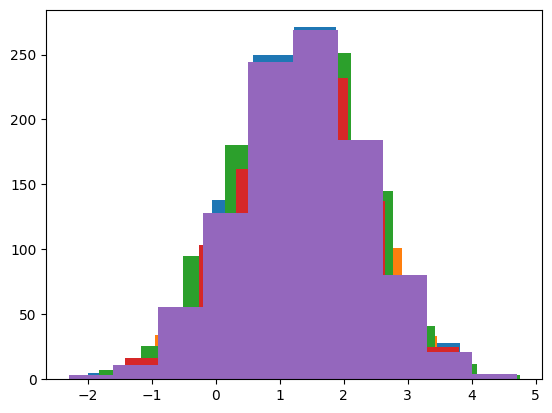

In [22]:

randarray = generate_randarrays(5, 1000)
sample2shift = get_normfacts(randarray)
normalized_randarray = apply_sampleshifts(randarray, sample2shift)
test_sampleshift(normalized_randarray)

In [23]:
#| include: false
import directlfq.visualizations as lfq_viz
import directlfq.utils as lfq_utils
def test_normalizing_between_samples(num_samples_quadratic):
    input_file = "../test_data/unit_tests/protein_normalization/peptides.txt.maxquant_peptides_benchmarking.aq_reformat.tsv"
    input_df = pd.read_csv(input_file, sep = '\t')
    input_df = lfq_utils.index_and_log_transform_input_df(input_df)
    input_df = input_df[[x for x in input_df.columns if "Shotgun" in x]]
    lfq_viz.plot_withincond_fcs(input_df)
    input_df_normalized = NormalizationManagerSamples(input_df, num_samples_quadratic=num_samples_quadratic).complete_dataframe
    lfq_viz.plot_withincond_fcs(input_df_normalized)
    assert_that_results_scatter_around_zero(input_df_normalized)


def assert_that_results_scatter_around_zero(input_df_normalized):
    median_intensities = input_df_normalized.median(axis=1)
    input_df_subtracted = input_df_normalized.subtract(median_intensities, axis=0)
    median_of_medians = input_df_subtracted.median(axis=0)
    assert (median_of_medians < 0.1).all()
    print("checked that close to zero")


In [24]:

test_normalizing_between_samples(100)
test_normalizing_between_samples(3)
test_normalizing_between_samples(1)

KeyError: 'None of [None, None] are in the columns'

## Learning Tests

In [ ]:
import numpy as np
import seaborn as sns

def test_taking_the_mean_along_an_axis():

    example_set = sns.load_dataset("iris").set_index("species")

    example_mean = example_set.mean(axis=1)

    assert example_mean.to_numpy()[3] == np.mean([4.6, 3.1, 1.5, 0.2])


In [ ]:

test_taking_the_mean_along_an_axis()